A **variational autoencoder (VAE)** resembles a classical autoencoder and is a neural network consisting of an encoder, a decoder and a loss function. They let us design complex generative models of data, and fit them to large data sets.

### The Data
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes the following information:

- Customers who left within the last month — the column is called Churn

- Services that each customer has signed up for — phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

- Customer account information — how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

- Demographic info about customers — gender, age range, and if they have partners and dependents.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.callbacks import Callback
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 12.0)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
def get_var_category(series):
    '''This function provides user readable values of the data types of a dataframe'''
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

In [7]:
print_categories(df)

customerID :  Text (Unique)
gender :  Categorical
SeniorCitizen :  Numerical
Partner :  Categorical
Dependents :  Categorical
tenure :  Numerical
PhoneService :  Categorical
MultipleLines :  Categorical
InternetService :  Categorical
OnlineSecurity :  Categorical
OnlineBackup :  Categorical
DeviceProtection :  Categorical
TechSupport :  Categorical
StreamingTV :  Categorical
StreamingMovies :  Categorical
Contract :  Categorical
PaperlessBilling :  Categorical
PaymentMethod :  Categorical
MonthlyCharges :  Numerical
TotalCharges :  Categorical
Churn :  Categorical


TotalChanges is a numerical field, but, it is interpreted as a categorical field in the above.

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

## EDA

### Visualize and Analyze Categorical Features

### Gender

In [107]:
gender_df = df.groupby(['Churn', 'gender']).size()
gender_df_per = gender_df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
gender_df_per.rename(columns={0:'Percentage'},inplace=True)
gender_df_per

,Churn,gender,Percentage
0,No,Female,49.265559
1,No,Male,50.734441
2,Yes,Female,50.240770
3,Yes,Male,49.759230


In [120]:
def create_barplot(data,x,y,title,y_label):
    grouped_df = data.groupby([x,y]).size()
    grouped_df_per = grouped_df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
    grouped_df_per.rename(columns={0:'Percentage'},inplace=True)
    g=sns.catplot(x=x,y='Percentage',
                      hue=y,
                      data=grouped_df_per, kind="bar",
                       legend_out=True)
    #g.set_titles("{col_name} {col_var}",fontsize=50)
    g.set_xticklabels(fontsize=30)
    g.set_xlabels(fontsize=30)
    g.set_ylabels(y_label,fontsize=30)
    #g.tick_params(labelsize=5)
    return g

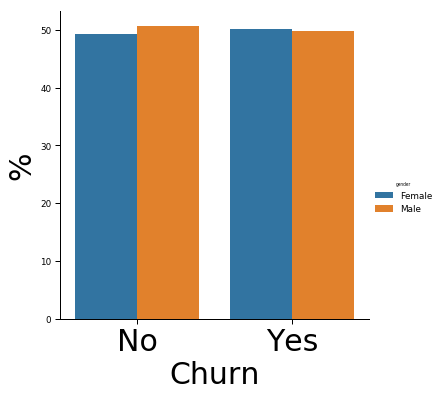

In [109]:
create_barplot(df,"Churn","gender", 'Churn by Gender', '%')

Gender does not seem to have an effect on the churn.

### Partner

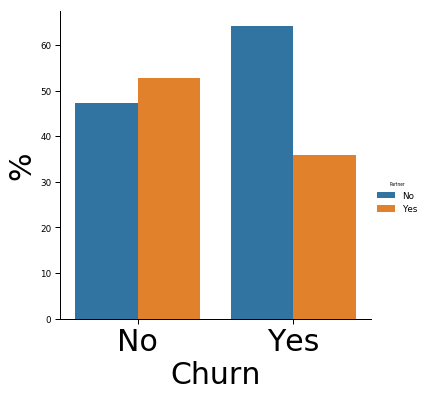

In [110]:
create_barplot(df,"Churn","Partner", 'Churn by Partner','%')

When partner exists, no churn is higher. When partner exists, churn is lower. Existence of a partner seems to inversely affect churn.

### Dependents

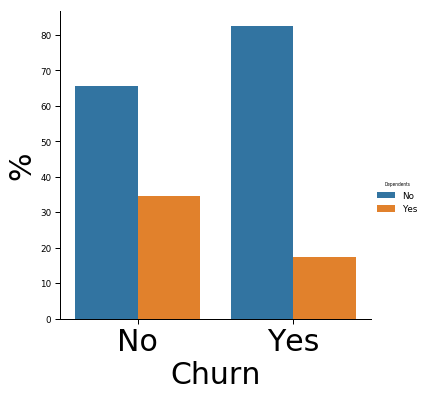

In [111]:
create_barplot(df,"Churn","Dependents", 'Churn by Dependents','%')

Having dependents seems to reduce the probability of churn.

### PhoneService

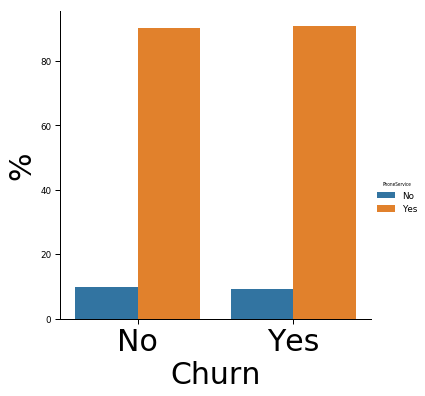

In [112]:
create_barplot(df,"Churn","PhoneService", 'Churn by PhoneService Subscription','%')

Whether customer have phone service or not does not seem to have an effect on the churn.

### MultipleLines

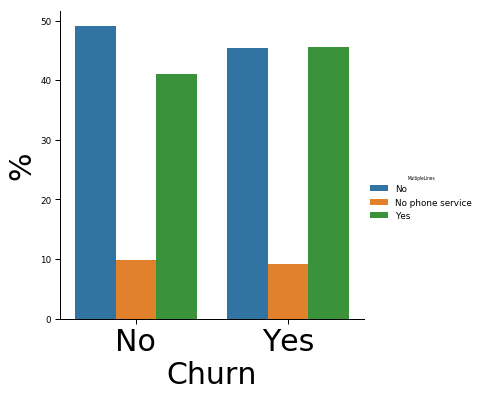

In [113]:
create_barplot(df,"Churn","MultipleLines", 'Churn based on Multiple Lines','%')

Whether customer signed up for MultipleLines or not does not seem to have an effect on the churn.

### InternetService

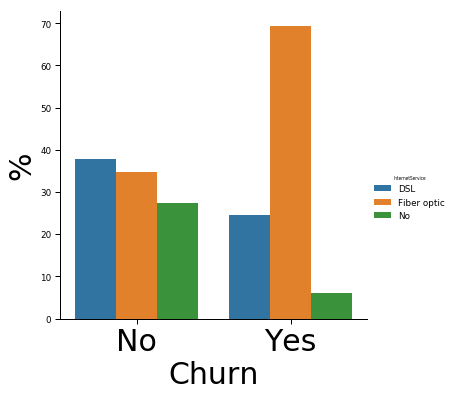

In [114]:
create_barplot(df,"Churn","InternetService", 'Churn based on Internet Service','%')

It seems customers who signed up for Fiber optic are most likely to churn.

### OnlineSecurity

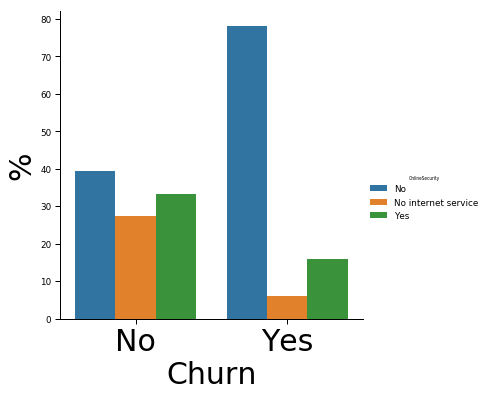

In [116]:
create_barplot(df,"Churn","OnlineSecurity", 'Churn based on Online Security Service','%')

Customers who did not sign up for OnlineSecurity are most likely to churn.

### OnlineBackup

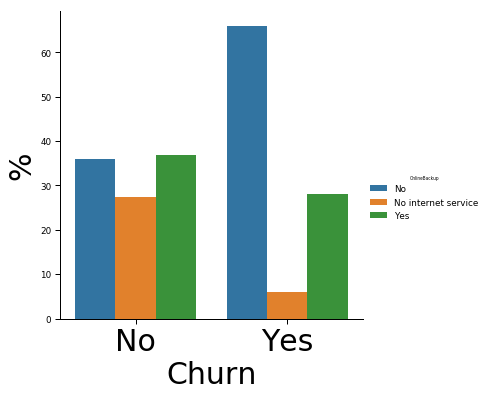

In [117]:
create_barplot(df,"Churn","OnlineBackup", 'Churn based on Online Backup Service','%')

Consumers who did not sign up for the online backup service are more likely to churn.

### DeviceProtection

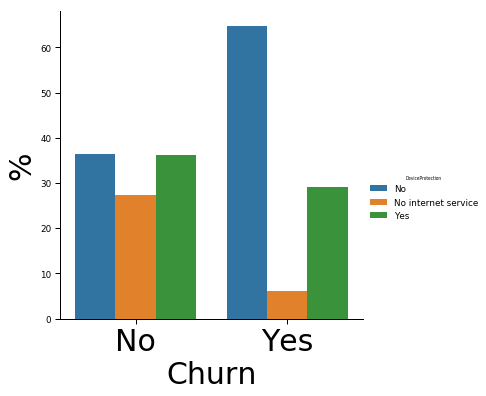

In [118]:
create_barplot(df,"Churn","DeviceProtection", 'Churn based on Device Protection Plan','%')